<a href="https://colab.research.google.com/github/wentao0420/IANNwTF_Group40/blob/main/IANNwTF_Week5_Group40.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **2 Assignment: CIFAR-10 Classification**

---

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import datetime as datetime
import tqdm

In [ ]:
(train_ds, test_ds), ds_info = tfds.load ('cifar10', split =['train', 'test'], as_supervised = True, with_info = True)

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='~/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {

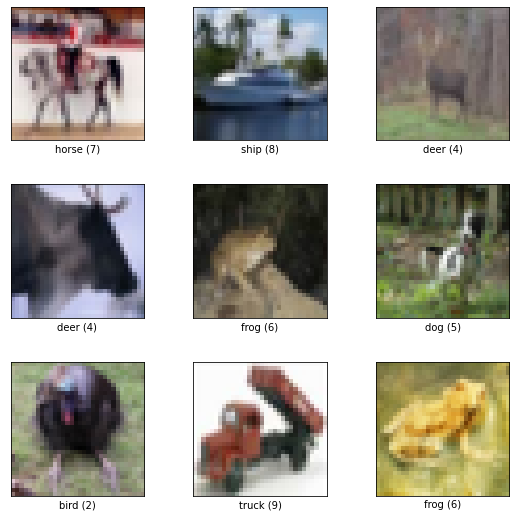

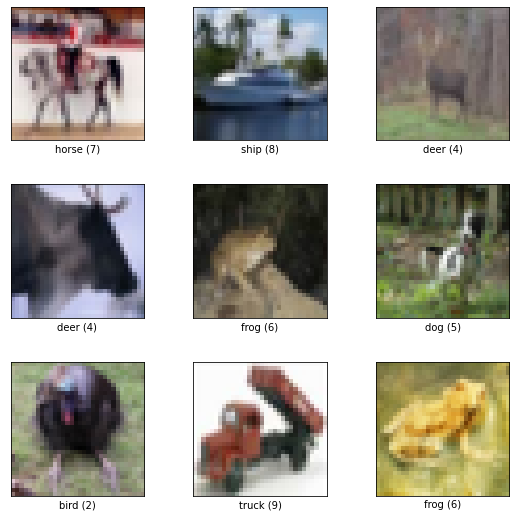

In [ ]:
tfds.show_examples(train_ds, ds_info)

## **2.1 Prepare the dataset**

---

In [ ]:
def preprocess(ds):
    # image should be float
    ds = ds.map(lambda x, t: (tf.cast(x, tf.float32), t))
    # image vector will here have values between -1 and 1
    ds = ds.map(lambda x,t: ((x/128.)-1., t))
    # target vector is converted into one-hot vector
    ds = ds.map(lambda x, t: (x, tf.one_hot(t, depth=10))) 
    # cache
    ds = ds.cache()
    # shuffle, batch, prefetch
    ds = ds.shuffle(1000)
    ds = ds.batch(32)
    ds = ds.prefetch(tf.data.AUTOTUNE) 

    return ds    

train_ds = preprocess(train_ds)
test_ds = preprocess(test_ds)

## **2.2 Build a Convolutional Neural Network model**

---

In [ ]:
class BasicConv(tf.keras.Model):
    def __init__(self):
        super(BasicConv, self).__init__()

        self.metrics_list = [tf.keras.metrics.BinaryAccuracy(name="accuracy"),
                             tf.keras.metrics.Mean(name="loss")]
        self.optimizer = tf.keras.optimizers.Adam()
        self.loss_function = tf.keras.losses.CategoricalCrossentropy()

        self.convlayer1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu') 
        self.convlayer2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu') 
        self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.convlayer3 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu') 
        self.convlayer4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.global_pool = tf.keras.layers.GlobalAvgPool2D()
        
        self.out = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = self.pooling(x)
        x = self.convlayer3(x)
        x = self.convlayer4(x)
        x = self.global_pool(x)
        x = self.out(x)
        return x

    @property
    def metrics(self):
        return self.metrics_list

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()

    @tf.function
    def train_step(self, data):
        img, label = data

        with tf.GradientTape() as tape:
            prediction = self(img, training=True)
            loss = self.loss_function(label, prediction)

        gradients = tape.gradient(loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # update the state of the metrics according to loss
        self.metrics[0].update_state(label, prediction)
        self.metrics[1].update_state(loss)

        # return a dictionary with metric names as keys and metric results as values
        return {m.name: m.result() for m in self.metrics}

    @tf.function
    def test_step(self, data):
        img, label = data

        prediction = self(img, training=False)
        loss = self.loss_function(label, prediction)

        # update the state of the metrics according to loss
        self.metrics[0].update_state(label, prediction)
        self.metrics[1].update_state(loss)

        # return a dictionary with metric names as keys and metric results as values
        return {m.name: m.result() for m in self.metrics}

In [ ]:
def create_summary_writers(config_name):
    
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    train_log_path = f"logs/{config_name}/{current_time}/train"
    val_log_path = f"logs/{config_name}/{current_time}/val"

    # log writer for training metrics
    train_summary_writer = tf.summary.create_file_writer(train_log_path)

    # log writer for validation metrics
    val_summary_writer = tf.summary.create_file_writer(val_log_path)
    
    return train_summary_writer, val_summary_writer

train_summary_writer, val_summary_writer = create_summary_writers(config_name="RUN1")

## **2.3 Train the network**
---

In [ ]:
# initialize lists for later visualiztion
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# initialize epochs and learning rate
epochs = 15
learning_rate = 0.01

# initialize model
model = BasicConv()

In [ ]:
def training():
    
    for epoch in range(epochs):
        print(f"Epoch: {epoch}, optimizer: {model.optimizer}")

        for data in tqdm.tqdm(train_ds, position=0, leave=True):
            metrics = model.train_step(data)

            with train_summary_writer.as_default():
                for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        print([f"train_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        for (key, value) in metrics.items():
            if key == "loss":
                train_losses.append(value.numpy())
            elif key == "accuracy":
                train_accuracies.append(value.numpy())

        # reset metric object
        model.reset_metrics()

        # evaluate on validation data
        for data in test_ds:
            metrics = model.test_step(data)

        # log validation metrics
        with val_summary_writer.as_default():
            for metric in model.metrics:
                tf.summary.scalar(f"{metric.name}", metric.result(), step = epoch)

        print([f"val_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # make a list of losses and accuracies
        for (key, value) in metrics.items():
            if key == "loss":
                val_losses.append(value.numpy())
            elif key == "accuracy":
                val_accuracies.append(value.numpy())

        # reset all metrics
        model.reset_metrics()

In [ ]:
training()

Epoch: 0, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fbb4a2504f0>


100%|██████████| 1563/1563 [04:21<00:00,  5.97it/s]


['train_accuracy: 0.9044860005378723', 'train_loss: 1.6955406665802002']
['val_accuracy: 0.9120299816131592', 'val_loss: 1.4528998136520386']
Epoch: 1, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fbb4a2504f0>


100%|██████████| 1563/1563 [03:28<00:00,  7.50it/s]


['train_accuracy: 0.9179040193557739', 'train_loss: 1.3350958824157715']
['val_accuracy: 0.9198799729347229', 'val_loss: 1.320800542831421']
Epoch: 2, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fbb4a2504f0>


100%|██████████| 1563/1563 [04:21<00:00,  5.97it/s]


['train_accuracy: 0.9271619915962219', 'train_loss: 1.1689397096633911']
['val_accuracy: 0.9281399846076965', 'val_loss: 1.1178433895111084']
Epoch: 3, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fbb4a2504f0>


100%|██████████| 1563/1563 [04:21<00:00,  5.97it/s]


['train_accuracy: 0.9328020215034485', 'train_loss: 1.0744320154190063']
['val_accuracy: 0.9342799782752991', 'val_loss: 1.0195540189743042']
Epoch: 4, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fbb4a2504f0>


100%|██████████| 1563/1563 [03:30<00:00,  7.43it/s]


['train_accuracy: 0.9359779953956604', 'train_loss: 1.0136473178863525']
['val_accuracy: 0.9374600052833557', 'val_loss: 0.9816007018089294']
Epoch: 5, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fbb4a2504f0>


100%|██████████| 1563/1563 [04:21<00:00,  5.97it/s]


['train_accuracy: 0.9388599991798401', 'train_loss: 0.961771547794342']
['val_accuracy: 0.9388300180435181', 'val_loss: 0.9519385099411011']
Epoch: 6, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fbb4a2504f0>


100%|██████████| 1563/1563 [04:21<00:00,  5.97it/s]


['train_accuracy: 0.9410840272903442', 'train_loss: 0.9227229356765747']
['val_accuracy: 0.9380800127983093', 'val_loss: 0.9640838503837585']
Epoch: 7, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fbb4a2504f0>


100%|██████████| 1563/1563 [04:21<00:00,  5.97it/s]


['train_accuracy: 0.9432700276374817', 'train_loss: 0.8899866938591003']
['val_accuracy: 0.9406499862670898', 'val_loss: 0.9130313396453857']
Epoch: 8, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fbb4a2504f0>


100%|██████████| 1563/1563 [04:21<00:00,  5.97it/s]


['train_accuracy: 0.9449779987335205', 'train_loss: 0.8542555570602417']
['val_accuracy: 0.9445499777793884', 'val_loss: 0.8491544127464294']
Epoch: 9, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fbb4a2504f0>


100%|██████████| 1563/1563 [04:21<00:00,  5.97it/s]


['train_accuracy: 0.9467099905014038', 'train_loss: 0.8275189399719238']
['val_accuracy: 0.945900022983551', 'val_loss: 0.8307065963745117']
Epoch: 10, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fbb4a2504f0>


100%|██████████| 1563/1563 [04:21<00:00,  5.97it/s]


['train_accuracy: 0.9481599926948547', 'train_loss: 0.7986836433410645']
['val_accuracy: 0.9460499882698059', 'val_loss: 0.8295464515686035']
Epoch: 11, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fbb4a2504f0>


100%|██████████| 1563/1563 [03:40<00:00,  7.10it/s]


['train_accuracy: 0.9499419927597046', 'train_loss: 0.7764937877655029']
['val_accuracy: 0.9475200176239014', 'val_loss: 0.8042967915534973']
Epoch: 12, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fbb4a2504f0>


100%|██████████| 1563/1563 [04:21<00:00,  5.97it/s]


['train_accuracy: 0.9510599970817566', 'train_loss: 0.7551191449165344']
['val_accuracy: 0.9466400146484375', 'val_loss: 0.8133100271224976']
Epoch: 13, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fbb4a2504f0>


100%|██████████| 1563/1563 [04:21<00:00,  5.97it/s]


['train_accuracy: 0.9525240063667297', 'train_loss: 0.7332654595375061']
['val_accuracy: 0.948390007019043', 'val_loss: 0.7834195494651794']
Epoch: 14, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fbb4a2504f0>


100%|██████████| 1563/1563 [04:21<00:00,  5.97it/s]


['train_accuracy: 0.9535599946975708', 'train_loss: 0.7120698690414429']
['val_accuracy: 0.9477999806404114', 'val_loss: 0.8024793267250061']


## **2.4 Visualization**

---

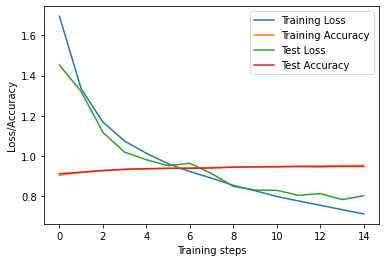

In [ ]:
fig = plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(train_accuracies)
line3, = plt.plot(val_losses)
line4, = plt.plot(val_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1, line2, line3, line4),("Training Loss","Training Accuracy","Test Loss","Test Accuracy"))
plt.show()